In [2]:
import imageio
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import LogNorm

# Project source files
from utils import *
from ols import *
from ridge import *
from lasso import *

In [73]:
# Setting up pyplot runtime configuration

from matplotlib.ticker import MaxNLocator

SMALL = 12
MEDIUM = 16
LARGE = 20
THICK = 4
THIN = 3
WIDE_FIG = (20,6)
SMALL_FIG = (6,6)
OPACITY = .25


plt.style.context('fivethirtyeight')
plt.rc('axes', facecolor='#E6E6E6', edgecolor='black', axisbelow=True, grid=True)
plt.rc('grid', color='white', linestyle='solid')
plt.rc('lines', linewidth=THICK)

plt.rc('font', size=SMALL, weight='bold')          # default text sizes
plt.rc('axes', titlesize=MEDIUM)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM)    # legend fontsize
plt.rc('figure', titlesize=LARGE)  # fontsize of the figure title

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

## OLS INTRO with CI$_{95}$ for $\mathbf{\hat{\beta}}$ 

In [11]:
NUM_SAMPLES = 1000
MAX_POLY_ORDER = 5
VAR_EPS = .05

x, y = randmesh(sn=NUM_SAMPLES)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, _ = franke_sampler(x.T[0], y.T[0], var_eps=VAR_EPS)

polynomial_orders = list(range(MAX_POLY_ORDER+1))

Plot OLS Confidence interval

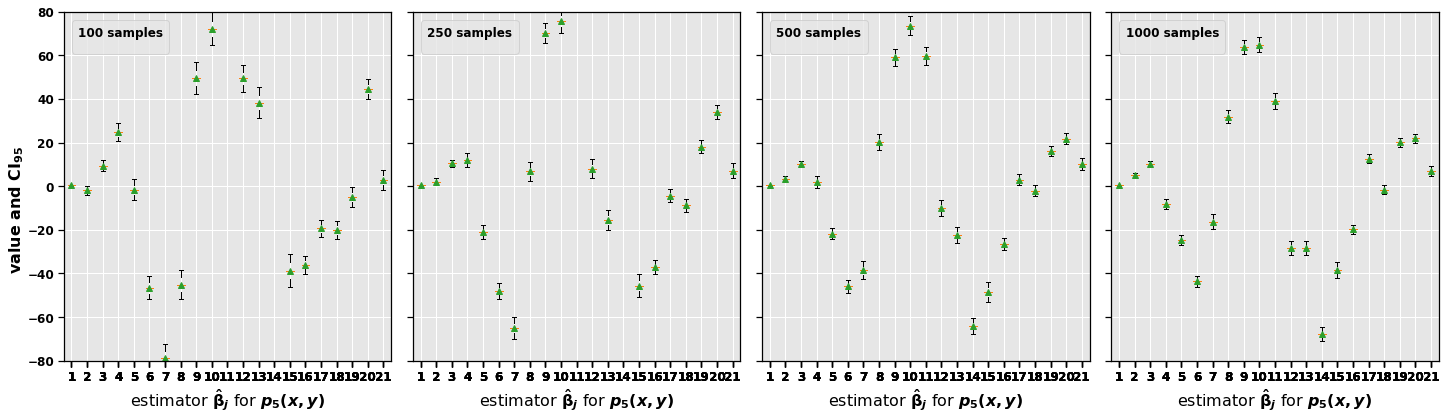

In [13]:
'''Plot OLS Confidence interval'''

fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=WIDE_FIG)
#fig.suptitle(r"OLS: CI$_{95}$ for estimator $\hat{\beta}$ with different sample sizes", fontsize=LARGE, weight='bold')
fig.text(-0.005, 0.5, 'value and CI$_{95}$', va='center', rotation='vertical', fontsize=MEDIUM)

ylim = (-80,80)
scaler = skl.preprocessing.StandardScaler(with_std=False)
samples = [100,250,500,1000]

for ax, sn in zip(axes, samples):
    X_down = X[:sn]
    z_down = z[:sn]
    X_down = scaler.fit_transform(X_down)
    X_down[:,0] = 1
    ax.boxplot(beta_hat_confidence_intervals(X_down, z_down, VAR_EPS, ci=95), showbox=False, showmeans=True)
    ax.set_ylim(*ylim)
    ax.legend([], title=f'{sn} samples', title_fontsize=SMALL, loc='upper left')
    ax.set_xlabel(r'estimator $\mathbf{\hat{\beta}}_j$ for $p_5(x,y)$')

plt.tight_layout()
plt.show()

Plot OLS MSE for different sample sizes

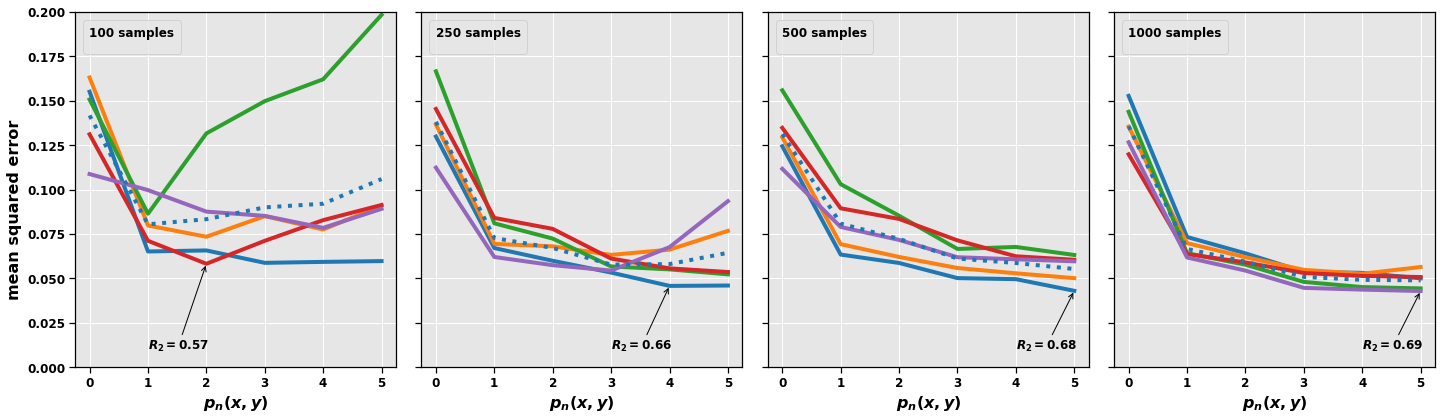

In [14]:
'''Plot OLS MSE with some different data sets and for different sample sizes'''


fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=WIDE_FIG)
#fig.suptitle(r"OLS: Train MSE variation for different sample sizes", fontsize=LARGE, weight='bold')
fig.text(-0.005, 0.5, 'mean squared error', va='center', rotation='vertical', fontsize=MEDIUM)

ylim = (0,.2)
samples = [100,250,500,1000]
ols_mse = np.ndarray(len(polynomial_orders))
ols_mse_avg = np.ndarray(len(polynomial_orders))

for ax, sn in zip(axes, samples):
    best_mse_val = 1
    best_mse_pn = -1
    for i in range(5):
        x, y = randmesh(sn=sn, random_state=i)
        X = make_design_matrix(x, y, pn=5)
        z, _, _ = franke_sampler(x.T[0], y.T[0], var_eps=VAR_EPS)
        X_train, X_test, z_train, z_test = skl.model_selection.train_test_split(X, z, train_size=.7)
        X_train, X_test = scale(X_train, X_test, with_std=False)
        for pn in polynomial_orders:
            X_train_pn = truncate_to_poly(X_train, pn)
            X_test_pn = truncate_to_poly(X_test, pn)
            beta_hat = np.linalg.inv(X_train_pn.T @ X_train_pn) @ X_train_pn.T @ z_train
            z_tilde = X_test_pn @ beta_hat
            ols_mse[pn] = mse(z_test, z_tilde)
        
        ols_mse_avg = (i*ols_mse_avg + ols_mse)/(i+1)
        if ols_mse.min() < best_mse_val:
            idx = ols_mse.argmin()
            best_mse_val = ols_mse[idx]
            best_mse_pn = polynomial_orders[idx]
        ax.plot(polynomial_orders, ols_mse)
    ax.plot(polynomial_orders, ols_mse_avg, ':', color=COLORS[0])
        
    # R2 annotation 
    xytext = (best_mse_pn-1, .01)
    xy = (best_mse_pn, best_mse_val)
    R2 = best_r2(best_mse_val, z_down)
    ax.annotate(f'$R_2 = {R2:.2f}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})
        
    ax.set_ylim(*ylim)
    ax.legend([], title=f'{sn} samples', title_fontsize=SMALL, loc='upper left')
    ax.set_xlabel(r"$p_n(x,y)$")

plt.tight_layout()
plt.show()

In [15]:
'''OLS Regression data set'''

NUM_SAMPLES = 1000
MAX_POLY_ORDER = 15
VAR_EPS = .03

x, y = randmesh(sn=NUM_SAMPLES)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, _ = franke_sampler(x.T[0], y.T[0], var_eps=VAR_EPS)

polynomial_orders = list(range(MAX_POLY_ORDER+1))

## FRANKE FUNCTION

Plotting OLS with Bootstrap

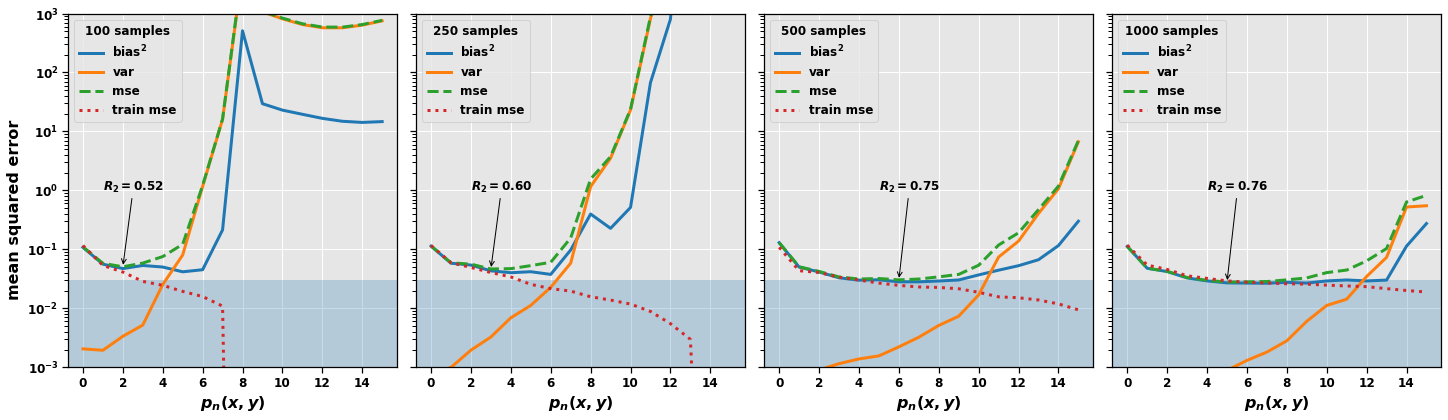

In [16]:
'''Plotting OLS with Bootstrap'''

fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=WIDE_FIG)
#plt.suptitle(r"OLS with Bootstrap: Bias-variance trade-off on different sample sizes", fontsize=LARGE, weight='bold')
fig.text(-0.005, 0.5, 'mean squared error', va='center', rotation='vertical', fontsize=MEDIUM)

ylim = (1E-3, 1E3)
samples = [100,250,500,1000]

for ax, sn in zip(axes, samples):
    X_down = X[:sn]
    z_down = z[:sn]
    f_down = f[:sn]
    ols_bs_df = run_ols_bootstrap(X_down, z_down, f_down, polynomial_orders=polynomial_orders, train_size=.7, bootstraps=25)
    ax.plot(polynomial_orders, ols_bs_df['test_bias'], linewidth=THIN)
    ax.plot(polynomial_orders, ols_bs_df['test_var'], linewidth=THIN)
    ax.plot(polynomial_orders, ols_bs_df['test_mse'], '--', linewidth=THIN)
    ax.plot(polynomial_orders, ols_bs_df['train_mse'], ':', linewidth=THIN)
    ax.legend(['bias$^2$', 'var', 'mse', 'train mse'], title=f'{sn} samples', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
    ax.set_ylim(*ylim)
    ax.set_xlabel(r"$p_n(x,y)$")
    ax.set_yscale('log')
    ax.axhspan(plt.ylim()[0], VAR_EPS, alpha=OPACITY)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # R2 annotation 
    best_idx = ols_bs_df['test_mse'].argmin()
    best_mse_pn = polynomial_orders[best_idx]
    best_mse_val = ols_bs_df['test_mse'].min()
    xytext = (best_mse_pn-1, 1)
    xy = (best_mse_pn, best_mse_val)
    R2 = best_r2(ols_bs_df['test_mse'], z_down)
    ax.annotate(f'$R_2 = {R2:.2f}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})

plt.tight_layout()
plt.show()

Plotting OLS with CV

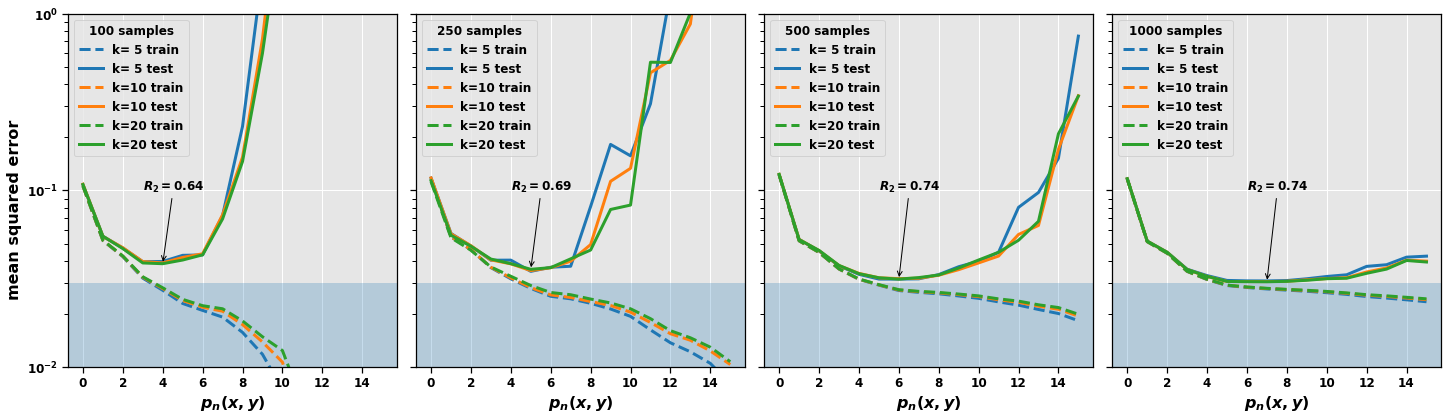

In [17]:
'''Plotting OLS with CV'''

fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=WIDE_FIG)
#plt.suptitle(r"OLS with $k$-fold CV: Train vs. Test MSE on different sample sizes", fontsize=LARGE, weight='bold')
fig.text(-0.005, 0.5, 'mean squared error', va='center', rotation='vertical', fontsize=MEDIUM)

ylim = (1E-2, 1E0)
samples = [100,250,500,1000]

for ax, sn in zip(axes, samples):
    X_down = X[:sn]
    z_down = z[:sn]
    legend = []
    for i, k in enumerate([5,10,20]):
        ols_k_df = run_ols_kfold(X_down, z_down, k=k, polynomial_orders=polynomial_orders)
        ax.plot(polynomial_orders, ols_k_df['train_mse'], '--', linewidth=THIN, color=COLORS[i])
        ax.plot(polynomial_orders, ols_k_df['test_mse'], linewidth=THIN, color=COLORS[i])
        legend += [f'k={k:2d} train', f'k={k:2d} test']
    ax.legend(legend, title=f'{sn} samples', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
    ax.set_ylim(*ylim)
    ax.set_xlabel(r"$p_n(x,y)$")
    ax.set_yscale('log')
    ax.axhspan(plt.ylim()[0], VAR_EPS, alpha=OPACITY)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # R2 annotation 
    best_idx = ols_k_df['test_mse'].argmin()
    best_mse_pn = polynomial_orders[best_idx]
    best_mse_val = ols_k_df['test_mse'].min()
    xytext = (best_mse_pn-1, .1)
    xy = (best_mse_pn, best_mse_val)
    R2 = best_r2(ols_k_df['test_mse'], z_down)
    ax.annotate(f'$R_2 = {R2:.2f}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})

plt.tight_layout()
plt.show()

In [39]:
'''Ridge Regression data set'''

NUM_SAMPLES = 1000
MAX_POLY_ORDER = 15
VAR_EPS = .03

x, y = randmesh(sn=NUM_SAMPLES)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, _ = franke_sampler(x.T[0], y.T[0], var_eps=VAR_EPS)

polynomial_orders = list(range(1,MAX_POLY_ORDER+1,1))
samples = [100,250,500,1000]

Ridge with Bootstrap

In [40]:
'''Running Ridge with Bootstrap'''

lambdas = np.logspace(-8, 1, 50)
ridge_bs_results = list()

for sn in samples:
    X_down = X[:sn]
    z_down = z[:sn]
    f_down = f[:sn]
    ridge_bs_df = run_ridge_bootstrap(X_down, z_down, f_down, polynomial_orders=polynomial_orders, lambdas=lambdas, train_size=.7, bootstraps=25)
    best_lambda, best_mse = best_lambda_mse(df=ridge_bs_df, polynomial_orders=polynomial_orders, col_prefix='test_mse_')
    ridge_bs_results.append((ridge_bs_df, best_lambda, best_mse))

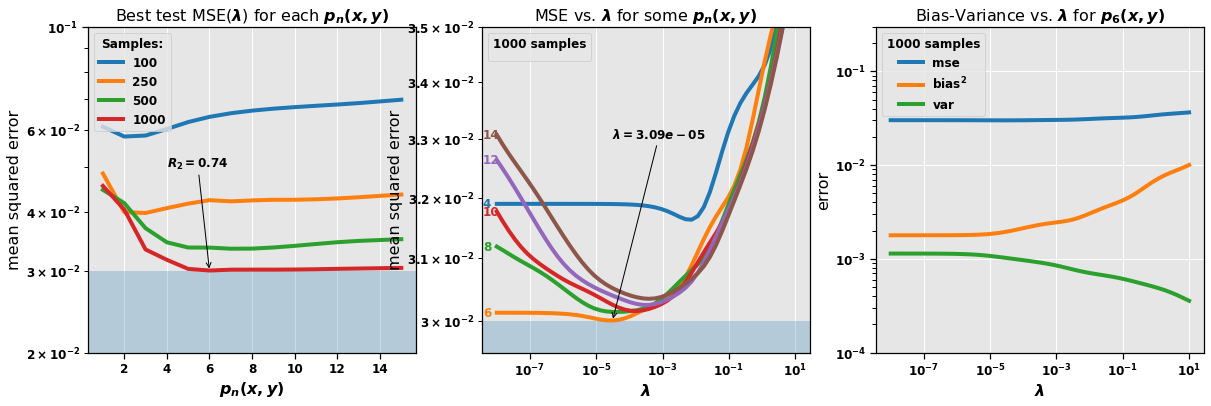

In [42]:
''' Plotting Ridge with Bootstrap '''

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=WIDE_FIG)
#fig.suptitle("Ridge with Bootstrap", fontsize=LARGE, weight='bold')

''' Best MSE '''
ax = axes[0]
ax.set_title("Best test MSE($\lambda$) for each $p_n(x,y)$")
ax.set_xlabel("$p_n(x,y)$")
ax.set_ylabel("mean squared error")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for result in ridge_bs_results:
    _, _, best_mse = result
    ax.plot(polynomial_orders, best_mse)
ax.axhspan(plt.ylim()[0], VAR_EPS, alpha=OPACITY)
ax.legend([str(sn) for sn in samples], title=f'Samples:', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
ax.set_yscale('log')
ax.set_ylim(.02, .2)
ax.set_ylim(.02,.1)

# Data set for annotations and other subplots
idx = 3
sn = samples[idx]
ridge_bs_df, best_lambda, best_mse = ridge_bs_results[idx]
best_mse_idx = np.argmin(best_mse)
best_mse_pn = polynomial_orders[best_mse_idx]
best_mse_val = best_mse[best_mse_idx]
best_mse_lambda_val = best_lambda[best_mse_idx]

# Annotate R2 for best MSE
xytext = (best_mse_pn-2, .05)
xy = (best_mse_pn, best_mse_val)
R2 = best_r2(best_mse, z[:sn])
ax.annotate(f'$R_2 = {R2:.2f}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})

''' MSE vs lambda '''
ax = axes[1]
ax.set_title(f"MSE vs. $\lambda$ for some $p_n(x,y)$")
plot_orders = [4,6,8,10,12,14]

names = [f'test_mse_{pn}' for pn in plot_orders]
for name in names:
    ax.plot(ridge_bs_df['lambda'], ridge_bs_df[name])
ax.axhspan(plt.ylim()[0], VAR_EPS, alpha=OPACITY)

for line, pn in zip(ax.lines, plot_orders):
    y = line.get_ydata()[0]
    ax.annotate(str(pn), xy=(0,y), xytext=(1,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=SMALL, va="center")    

ax.legend([], title=f'{sn} samples', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
ax.set_xlabel("$\lambda$")
ax.set_ylabel("mean squared error")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(.0295, .035)

# Annotate best lambda
xytext = (best_mse_lambda_val, .033)
xy = (best_mse_lambda_val, best_mse_val)
ax.annotate(f'$\lambda = {best_mse_lambda_val:.2e}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})

''' Bias-Variance '''
ax = axes[2]
pn = best_mse_pn
ax.set_title(f"Bias-Variance vs. $\lambda$ for $p_{{{pn}}}(x,y)$")
ax.plot(ridge_bs_df['lambda'], ridge_bs_df[f'test_mse_{pn}'])
ax.plot(ridge_bs_df['lambda'], ridge_bs_df[f'test_bias_{pn}'])
ax.plot(ridge_bs_df['lambda'], ridge_bs_df[f'test_var_{pn}'])
ax.legend(['mse', 'bias$^2$', 'var'], title=f'{sn} samples', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
ax.set_xlabel("$\lambda$")
ax.set_ylabel("error")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(.0001, .3)

plt.show()

Ridge with CV

In [58]:
'''Running Ridge with CV'''

lambdas = np.logspace(-7, -1, 50)
ridge_k_train_results = list()
ridge_k_test_results = list()
for sn in samples:
    X_down = X[:sn]
    z_down = z[:sn]
    ridge_k_df = run_ridge_kfold(X_down, z_down, k=5, polynomial_orders=polynomial_orders, lambdas=lambdas)
    best_lambda, best_mse = best_lambda_mse(df=ridge_k_df, polynomial_orders=polynomial_orders, col_prefix='train_mse_')
    ridge_k_train_results.append((ridge_k_df, best_lambda, best_mse))
    best_lambda, best_mse = best_lambda_mse(df=ridge_k_df, polynomial_orders=polynomial_orders, col_prefix='test_mse_')
    ridge_k_test_results.append((ridge_k_df, best_lambda, best_mse))

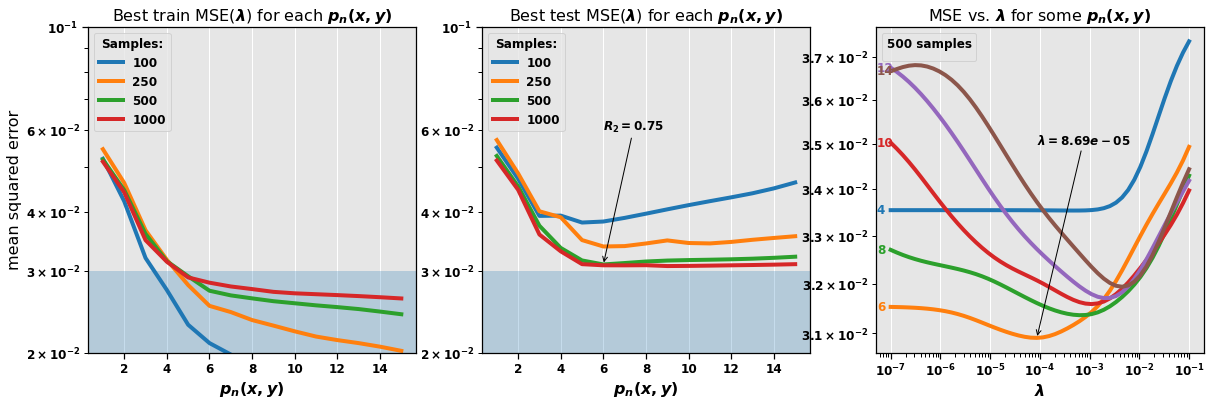

In [60]:
'''Plotting Ridge with CV'''

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=WIDE_FIG)
#fig.suptitle("Ridge with CV", fontsize=LARGE, weight='bold')


''' Best Train MSE '''
ax = axes[0]
ax.set_title("Best train MSE($\lambda$) for each $p_n(x,y)$")
ax.set_xlabel("$p_n(x,y)$")
ax.set_ylabel("mean squared error")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for result in ridge_k_train_results:
    _, _, best_mse = result
    ax.plot(polynomial_orders, best_mse)
ax.set_ylim(.02,.1)
ax.axhspan(plt.ylim()[0], VAR_EPS, alpha=OPACITY)
ax.legend([str(sn) for sn in samples], title=f'Samples:', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
ax.set_yscale('log')


''' Best Test MSE '''
ax = axes[1]
ax.set_title("Best test MSE($\lambda$) for each $p_n(x,y)$")
ax.set_xlabel("$p_n(x,y)$")
#ax.set_ylabel("mean squared error")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for result in ridge_k_test_results:
    _, _, best_mse = result
    ax.plot(polynomial_orders, best_mse)
ax.set_ylim(.02,.1)
ax.axhspan(plt.ylim()[0], VAR_EPS, alpha=OPACITY)
ax.legend([str(sn) for sn in samples], title=f'Samples:', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
ax.set_yscale('log')

# Data set for annotations and other subplots
idx = 2
sn = samples[idx]
ridge_k_df, best_lambda, best_mse = ridge_k_test_results[idx]
best_mse_idx = np.argmin(best_mse)
best_mse_pn = polynomial_orders[best_mse_idx]
best_mse_val = best_mse[best_mse_idx]
best_mse_lambda_val = best_lambda[best_mse_idx]

# Annotate R2 for best MSE
xytext = (best_mse_pn, .060)
xy = (best_mse_pn, best_mse_val)
R2 = best_r2(best_mse, z[:sn])
ax.annotate(f'$R_2 = {R2:.2f}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})


''' Test MSE vs lambda '''
ax = axes[2]
ax.set_title(f"MSE vs. $\lambda$ for some $p_n(x,y)$")
plot_orders = [4,6,8,10,12,14]
names = [f'test_mse_{pn}' for pn in plot_orders]
for name in names:
    ax.plot(ridge_k_df['lambda'], ridge_k_df[name])
    
for line, pn in zip(ax.lines, plot_orders):
    y = line.get_ydata()[0]
    ax.annotate(str(pn), xy=(0,y), xytext=(1,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=SMALL, va="center")    

ax.legend([], title=f'{sn} samples', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
ax.set_xlabel("$\lambda$")
#ax.set_ylabel("mean squared error")
ax.set_xscale('log')
ax.set_yscale('log')

# Annotate best lambda
xytext = (best_mse_lambda_val, .035)
xy = (best_mse_lambda_val, best_mse_val)
ax.annotate(f'$\lambda = {best_mse_lambda_val:.2e}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})
    
plt.show()

In [64]:
'''LASSO Regression data set'''

NUM_SAMPLES = 1000
MAX_POLY_ORDER = 15
VAR_EPS = .03

x, y = randmesh(sn=NUM_SAMPLES, random_state=0)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, _ = franke_sampler(x.T[0], y.T[0], var_eps=VAR_EPS)

polynomial_orders = list(range(1,MAX_POLY_ORDER+1,1))
samples = [100,250,500,1000]

LASSO with Bootstrap

In [65]:
'''Running LASSO with Bootstrap'''

skl_lasso_opts = {'max_iter':1E4, 'fit_intercept':False, 'warm_start':True, 'precompute':True, 'tol':.001, 'selection':'random', 'random_state':0}
lambdas = np.logspace(-7, -1, 25)
lasso_bs_results = list()
for sn in samples:
    X_down = X[:sn]
    z_down = z[:sn]
    f_down = f[:sn]
    lasso_bs_df = lasso_bootstrap(X_down, z_down, f_down, polynomial_orders=polynomial_orders, lambdas=lambdas, train_size=.7, bootstraps=25, **skl_lasso_opts)
    best_lambda, best_mse = best_lambda_mse(df=lasso_bs_df, polynomial_orders=polynomial_orders, col_prefix='test_mse_')
    lasso_bs_results.append((lasso_bs_df, best_lambda, best_mse))

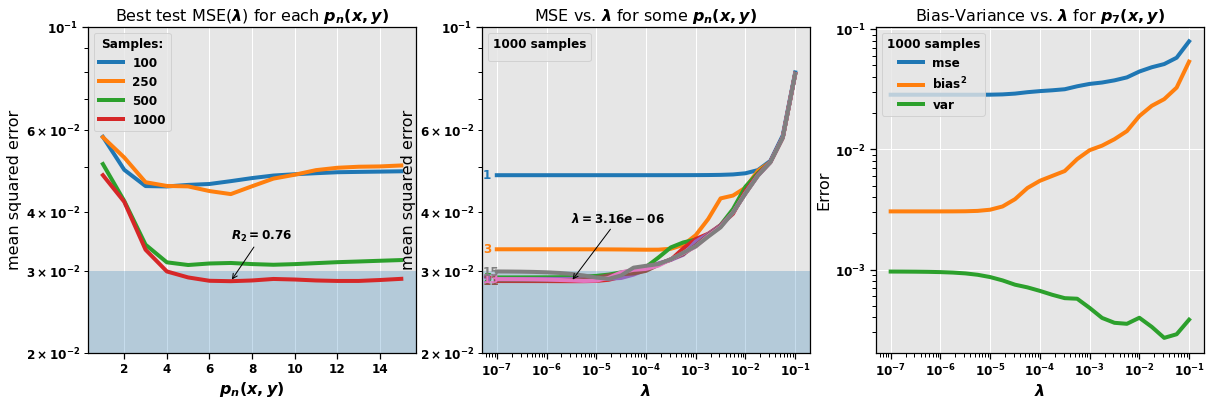

In [71]:
''' Plotting LASSO with Bootstrap '''

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=WIDE_FIG)
#fig.suptitle("LASSO with Bootstrap", fontsize=LARGE, weight='bold')

''' Best MSE '''
ax = axes[0]
ax.set_title("Best test MSE($\lambda$) for each $p_n(x,y)$")
ax.set_xlabel("$p_n(x,y)$")
ax.set_ylabel("mean squared error")
ax.set_yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for result in lasso_bs_results:
    _, _, best_mse = result
    ax.plot(polynomial_orders, best_mse)
ax.axhspan(plt.ylim()[0], VAR_EPS, alpha=OPACITY)
ax.legend([str(sn) for sn in samples], title=f'Samples:', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
ax.set_ylim(.02,.1)

# Data set for annotations and other subplots
idx = 3
sn = samples[idx]
lasso_bs_df, best_lambda, best_mse = lasso_bs_results[idx]
best_mse_idx = np.argmin(best_mse)
best_mse_pn = polynomial_orders[best_mse_idx]
best_mse_val = best_mse[best_mse_idx]
best_mse_lambda_val = best_lambda[best_mse_idx]

# Annotate R2 for best MSE
xytext = (best_mse_pn, .035)
xy = (best_mse_pn, best_mse_val)
R2 = best_r2(best_mse, z[:sn])
ax.annotate(f'$R_2 = {R2:.2f}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})

''' MSE vs lambda '''
ax = axes[1]
ax.set_title(f"MSE vs. $\lambda$ for some $p_n(x,y)$")
plot_orders = [1,3,5,7,9,11,13,15]
names = [f'test_mse_{pn}' for pn in plot_orders]
for name in names:
    ax.plot(lasso_bs_df['lambda'], lasso_bs_df[name])
ax.axhspan(plt.ylim()[0], VAR_EPS, alpha=OPACITY)
    
for line, pn in zip(ax.lines, plot_orders):
    y = line.get_ydata()[0]
    ax.annotate(str(pn), xy=(0,y), xytext=(1,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=SMALL, va="center")    

ax.legend([], title=f'{sn} samples', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
ax.set_xlabel("$\lambda$")
ax.set_ylabel("mean squared error")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(.02,.1)

# Annotate best lambda
xytext = (best_mse_lambda_val, .038)
xy = (best_mse_lambda_val, best_mse_val)
ax.annotate(f'$\lambda = {best_mse_lambda_val:.2e}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})

''' Bias-Variance '''
ax = axes[2]
pn = best_mse_pn
ax.set_title(f"Bias-Variance vs. $\lambda$ for $p_{{{pn}}}(x,y)$")
ax.plot(lasso_bs_df['lambda'], lasso_bs_df[f'test_mse_{pn}'])
ax.plot(lasso_bs_df['lambda'], lasso_bs_df[f'test_bias_{pn}'])
ax.plot(lasso_bs_df['lambda'], lasso_bs_df[f'test_var_{pn}'])
ax.legend(['mse', 'bias$^2$', 'var'], title=f'{sn} samples', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
ax.set_xlabel("$\lambda$")
ax.set_ylabel("Error")
ax.set_xscale('log')
ax.set_yscale('log')
    
plt.show()

LASSO with CV

In [66]:
'''Running LASSO with CV'''

skl_lasso_opts = {'max_iter':1E4, 'fit_intercept':False, 'warm_start':True, 'precompute':True, 'tol':.01, 'selection':'random', 'random_state':0}
lambdas = np.logspace(-7, -1, 25)
lasso_k_train_results = list()
lasso_k_test_results = list()
for sn in samples:
    X_down = X[:sn]
    z_down = z[:sn]
    lasso_k_df = lasso_kfold(X_down, z_down, k=5, polynomial_orders=polynomial_orders, lambdas=lambdas, **skl_lasso_opts)
    best_lambda, best_mse = best_lambda_mse(df=lasso_k_df, polynomial_orders=polynomial_orders, col_prefix='train_mse_')
    lasso_k_train_results.append((lasso_k_df, best_lambda, best_mse))
    best_lambda, best_mse = best_lambda_mse(df=lasso_k_df, polynomial_orders=polynomial_orders, col_prefix='test_mse_')
    lasso_k_test_results.append((lasso_k_df, best_lambda, best_mse))

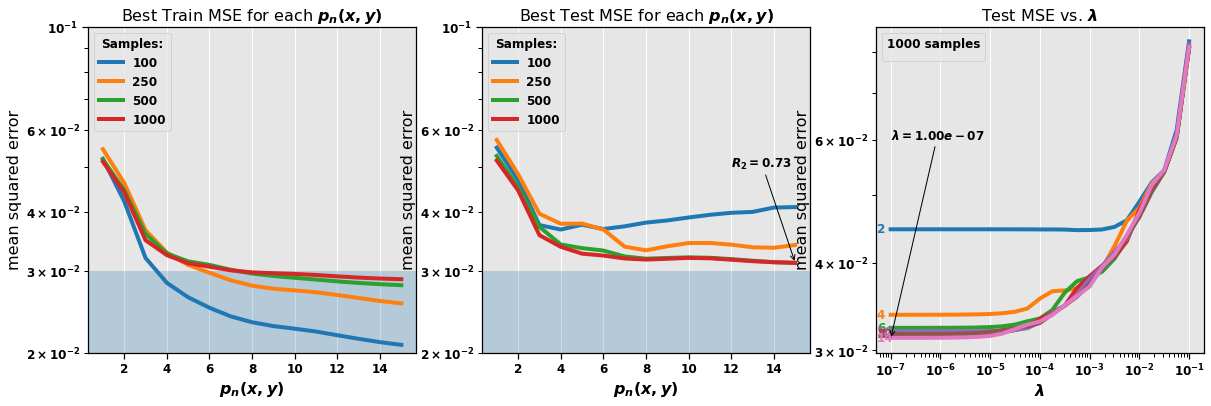

In [69]:
'''Plotting LASSO with CV'''

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=WIDE_FIG)
#fig.suptitle("LASSO with CV", fontsize=LARGE, weight='bold')

''' Best Train MSE '''
ax = axes[0]
ax.set_title("Best Train MSE for each $p_n(x,y)$")
ax.set_xlabel("$p_n(x,y)$")
ax.set_ylabel("mean squared error")
ax.set_yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for result in lasso_k_train_results:
    _, _, best_mse = result
    ax.plot(polynomial_orders, best_mse)
ax.axhspan(plt.ylim()[0], VAR_EPS, alpha=OPACITY)
ax.legend([str(sn) for sn in samples], title=f'Samples:', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
ax.set_ylim(.02,.1)

''' Best Test MSE '''
ax = axes[1]
ax.set_title("Best Test MSE for each $p_n(x,y)$")
ax.set_xlabel("$p_n(x,y)$")
ax.set_ylabel("mean squared error")
ax.set_yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for result in lasso_k_test_results:
    _, _, best_mse = result
    ax.plot(polynomial_orders, best_mse)
ax.axhspan(plt.ylim()[0], VAR_EPS, alpha=OPACITY)
ax.legend([str(sn) for sn in samples], title=f'Samples:', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
ax.set_ylim(.02,.1)

# Data set for annotations and other subplots
idx = 3
sn = samples[idx]
lasso_k_df, best_lambda, best_mse = lasso_k_test_results[idx]
best_mse_idx = np.argmin(best_mse)
best_mse_pn = polynomial_orders[best_mse_idx]
best_mse_val = best_mse[best_mse_idx]
best_mse_lambda_val = best_lambda[best_mse_idx]

# Annotate R2 for best MSE
xytext = (best_mse_pn-3, .05)
xy = (best_mse_pn, best_mse_val)
R2 = best_r2(best_mse, z[:sn])
ax.annotate(f'$R_2 = {R2:.2f}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})


''' Test MSE vs lambda '''
ax = axes[2]
ax.set_title(f"Test MSE vs. $\lambda$")
plot_orders = [2,4,6,8,10,12,14]
names = [f'test_mse_{pn}' for pn in plot_orders]
for name in names:
    ax.plot(lasso_k_df['lambda'], lasso_k_df[name])

for line, pn in zip(ax.lines, plot_orders):
    y = line.get_ydata()[0]
    ax.annotate(str(pn), xy=(0,y), xytext=(1,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=SMALL, va="center")    

ax.legend([], title=f'{sn} samples', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
ax.set_xlabel("$\lambda$")
ax.set_ylabel("mean squared error")
ax.set_xscale('log')
ax.set_yscale('log')


# Annotate best lambda
xytext = (best_mse_lambda_val, .06)
xy = (best_mse_lambda_val, best_mse_val)
ax.annotate(f'$\lambda = {best_mse_lambda_val:.2e}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})
    
plt.show()

/home/olav/anaconda3/envs/fys-stk4155/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.57773183841524, tolerance: 2.70679968417458
  model = cd_fast.enet_coordinate_descent_gram(


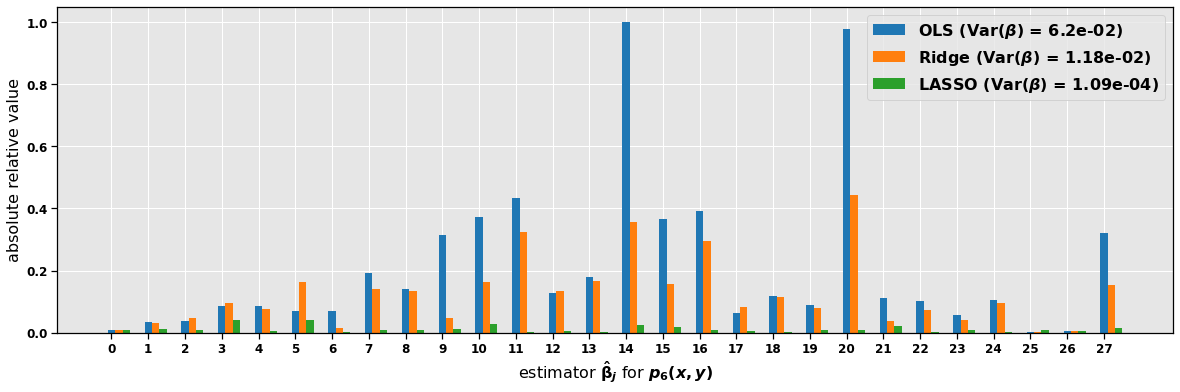

osl zeros: 0
ridge zeros: 0
lasso zeros: 0


In [127]:
NUM_SAMPLES = 1000
MAX_POLY_ORDER = 6
VAR_EPS = .03

x, y = randmesh(sn=NUM_SAMPLES)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, _ = franke_sampler(x.T[0], y.T[0], var_eps=VAR_EPS)

scaler = skl.preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X[:,0] = 1

beta_hat_ols = np.linalg.pinv(X) @ z
beta_hat_ols = np.abs(beta_hat_ols[:,0])
scaler = beta_hat_ols.max()
beta_hat_ols = beta_hat_ols / scaler

lmd = 8.7E-5
L = lmd*np.identity(X.shape[1])
beta_hat_ridge = np.linalg.inv(X.T @ X + L) @ X.T @ z
beta_hat_ridge = np.abs(beta_hat_ridge[:,0])
beta_hat_ridge = beta_hat_ridge / scaler

lmd = 3.2E-6
skl_lasso_opts = {'max_iter':1E4, 'fit_intercept':False, 'warm_start':True, 'precompute':True, 'tol':.01, 'selection':'random', 'random_state':0}
lasso = skl.linear_model.Lasso(alpha=lmd, **skl_lasso_opts)
lasso.fit(X, z)
beta_hat_lasso = lasso.coef_
beta_hat_lasso = np.abs(beta_hat_lasso) / scaler

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=WIDE_FIG)
ax = axes
indexes = np.arange(len(beta_hat_ols))
width = .2
ax.bar(indexes, beta_hat_ols, width)
ax.bar(indexes+width, beta_hat_ridge, width)
ax.bar(indexes+2*width, beta_hat_lasso, width)
ax.set_xticks([j for j in range(len(beta_hat_ols))])
ax.legend([fr'OLS (Var(${{\beta}}$) = {np.var(beta_hat_ols):.1e})', fr'Ridge (Var(${{\beta}}$) = {np.var(beta_hat_ridge):.2e})', fr'LASSO (Var(${{\beta}}$) = {np.var(beta_hat_lasso):.2e})'])
ax.set_xlabel(r'estimator $\mathbf{\hat{\beta}}_j$ for $p_6(x,y)$')
ax.set_ylabel(r'absolute relative value')

plt.show()

print(f'osl zeros: {len(indexes) - np.count_nonzero(beta_hat_ols)}')
print(f'ridge zeros: {len(indexes) - np.count_nonzero(beta_hat_ridge)}')
print(f'lasso zeros: {len(indexes) - np.count_nonzero(beta_hat_lasso)}')

## GEO DATA

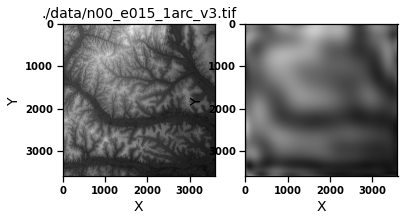

In [20]:
'''Reading data'''
file_name = './data/n00_e015_1arc_v3.tif'
terrain = imageio.imread(file_name)
plt.figure()
plt.subplot(121)
plt.title(file_name)
plt.imshow(terrain, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(False)

plt.subplot(122)
plt.imshow(img, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(False)
plt.show()


plt.show()

In [128]:
from utils import *
file_name = './data/n00_e015_1arc_v3.tif'

NUM_SAMPLES = 7500
MAX_POLY_ORDER = 30

x, y, z, xyz_norm = image_sampler(file_name, NUM_SAMPLES)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)

polynomial_orders = list(range(MAX_POLY_ORDER+1))

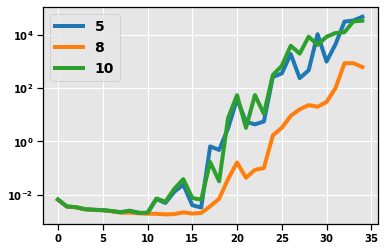

In [8]:
'''Running OLS with CV'''
ols_varying_k_results = list()
sn = 1000
X_down = X[:sn]
z_down = z[:sn]
pols = list(range(35))
for k in [5,8,10]:
    ols_k_df = run_ols_kfold(X_down, z_down, k=k, polynomial_orders=pols)
    ols_varying_k_results.append(ols_k_df)

plt.figure()
plt.subplot(111)
for df in ols_varying_k_results:
    plt.plot(pols, df['test_mse'])
plt.yscale('log')
plt.legend([5,8,10])
plt.show()

In [129]:
'''Running OLS with CV'''

ols_varying_sn_results = list()
samples = [2500,5000,7500,10000]

for sn in samples:
    X_down = X[:sn]
    z_down = z[:sn]
    ols_k_df = run_ols_kfold(X_down, z_down, k=5, polynomial_orders=polynomial_orders)
    ols_varying_sn_results.append(ols_k_df)
    


sn = 6000
X_down = X[:sn]
z_down = z[:sn]
ols_k_df = run_ols_kfold(X_down, z_down, k=5, polynomial_orders=polynomial_orders)
#ols_varying_sn_results.append(ols_k_df)
ols_varying_sn_results[-1] = ols_k_df   

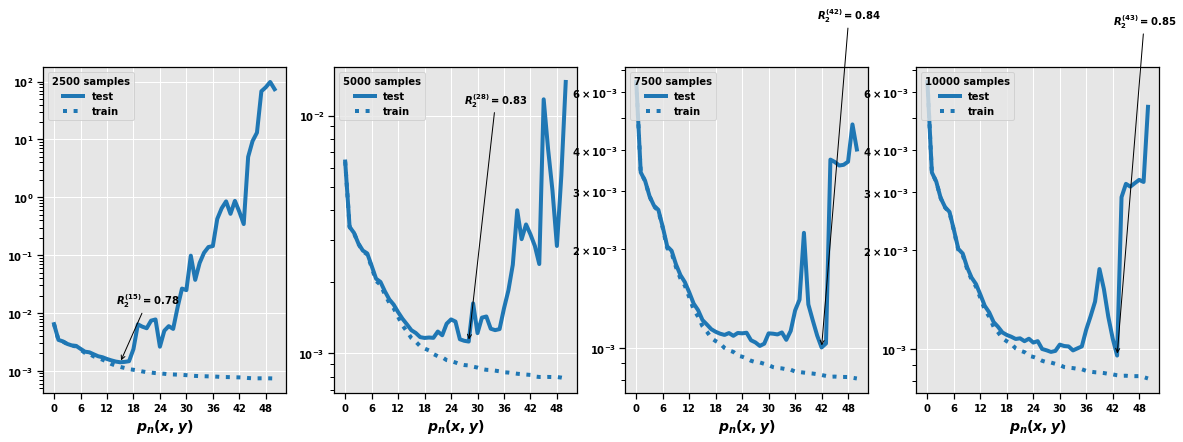

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=WIDE_FIG)
#fig.suptitle("Ridge with CV", fontsize=LARGE, weight='bold')

for ax, sn, df in zip(axes, samples, ols_varying_sn_results):
    ax.plot(polynomial_orders, df['test_mse'], color=COLORS[0])
    ax.plot(polynomial_orders, df['train_mse'], ':', color=COLORS[0])
    ax.set_yscale('log')
    ax.legend(['test','train'], title=f'{sn} samples', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
    ax.set_xlabel(r"$p_n(x,y)$")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # R2 annotation 
    best_idx = df['test_mse'].argmin()
    best_mse_pn = polynomial_orders[best_idx]
    best_mse_val = df['test_mse'].min()
    xytext = (best_mse_pn-1, best_mse_val*10)
    xy = (best_mse_pn, best_mse_val)
    R2 = best_r2(df['test_mse'], z_down)
    ax.annotate(f'$R_2^{{({best_mse_pn})}} = {R2:.2f}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})
    
    
plt.show()

In [4]:

file_name = './data/n00_e015_1arc_v3.tif'

NUM_SAMPLES = 7500
MAX_POLY_ORDER = 30

x, y, z, xyz_norm = image_sampler(file_name, NUM_SAMPLES)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)

polynomial_orders = list(range(1,MAX_POLY_ORDER+1))

In [56]:
pn = 28
sn = 7500
X_down = X[:sn]
X_down = truncate_to_poly(X_down, pn)
z_down = z[:sn]
beta_hat = np.linalg.pinv(X_down) @ z_down
z_tilde = X_down @ beta_hat

In [57]:
x_dim, y_dim, z_norm = xyz_norm

img = np.ndarray((x_dim, y_dim))
generate_image(img, pn, beta_hat)
img = img * z_norm
img = img.astype(int)

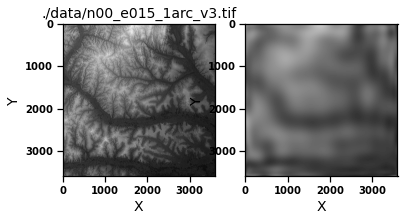

In [58]:
'''Reading data'''
file_name = './data/n00_e015_1arc_v3.tif'
terrain = imageio.imread(file_name)
plt.figure()
plt.subplot(121)
plt.title(file_name)
plt.imshow(terrain, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(False)

plt.subplot(122)
plt.imshow(img, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(False)
plt.show()


plt.show()

In [59]:
polynomial_orders = list(range(30+1))

In [5]:
'''Running Ridge with CV'''

sn = 5000
lambdas = np.logspace(-11, 0, 50)

X_down = X[:sn]
z_down = z[:sn]
ridge_df = run_ridge_kfold(X_down, z_down, k=5, polynomial_orders=polynomial_orders, lambdas=lambdas)



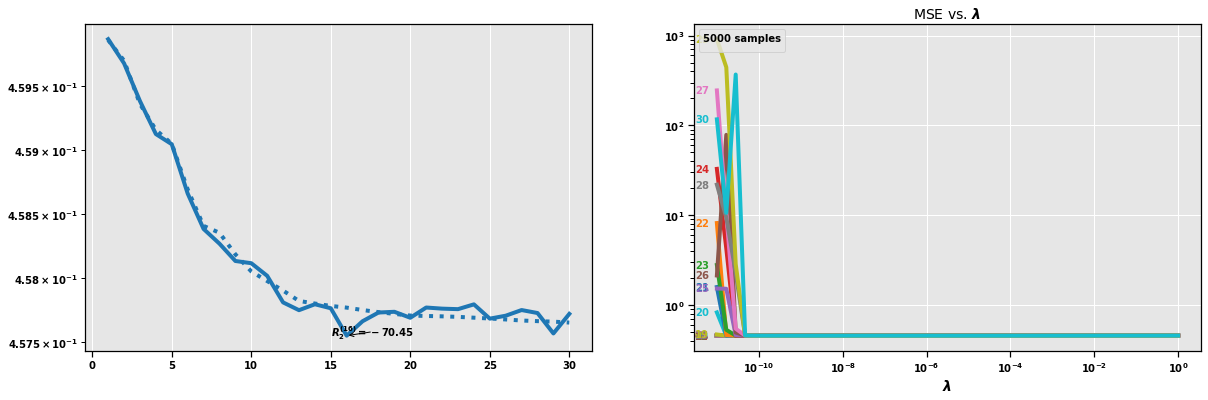

In [6]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=WIDE_FIG)


ax = axes[0]
test_best_lambda, test_best_mse = best_lambda_mse(df=ridge_df, polynomial_orders=polynomial_orders, col_prefix='test_mse_')
train_best_lambda, train_best_mse = best_lambda_mse(df=ridge_df, polynomial_orders=polynomial_orders, col_prefix='train_mse_')
ax.plot(polynomial_orders, test_best_mse, color=COLORS[0])
ax.plot(polynomial_orders, train_best_mse, ':', color=COLORS[0])
ax.set_yscale('log')


# R2 annotation 
best_idx = test_best_mse.argmin()
best_mse_pn = polynomial_orders[best_idx]
best_mse_val = test_best_mse.min()
xytext = (best_mse_pn-1, best_mse_val)
xy = (best_mse_pn, best_mse_val)
R2 = best_r2(test_best_mse, z_down)
ax.annotate(f'$R_2^{{({best_mse_pn})}} = {R2:.2f}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})


''' MSE vs lambda '''
ax = axes[1]
ax.set_title(f"MSE vs. $\lambda$")
plot_orders = [3,7,10,13,15]
plot_orders = polynomial_orders
names = [f'test_mse_{pn}' for pn in plot_orders]
for name in names:
    ax.plot(ridge_df['lambda'], ridge_df[name])

for line, pn in zip(ax.lines, plot_orders):
    y = line.get_ydata()[0]
    ax.annotate(str(pn), xy=(0,y), xytext=(1,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=SMALL, va="center")    

ax.legend([], title=f'{sn} samples', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
ax.set_xlabel("$\lambda$")
#ax.set_ylabel("MSE")
ax.set_xscale('log')
ax.set_yscale('log')

# Annotate best lambda
#xytext = (best_mse_lambda_val, .04)
#xy = (best_mse_lambda_val, best_mse_val)
#ax.annotate(f'$\lambda = {best_mse_lambda_val:.2e}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})


plt.show()

In [4]:

file_name = './data/n00_e015_1arc_v3.tif'

NUM_SAMPLES = 1000
MAX_POLY_ORDER = 50

x, y, z, xyz_norm = image_sampler(file_name, NUM_SAMPLES)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)

polynomial_orders = list(range(MAX_POLY_ORDER+1))

In [5]:
X.shape

(7500, 496)

In [6]:
'''Running LASSO with CV'''

skl_lasso_opts = {'max_iter':5E5, 'fit_intercept':False, 'warm_start':True, 'precompute':True, 'tol':.001, 'selection':'random', 'random_state':0}
lambdas = np.logspace(-9, -0, 50)
polynomial_orders = [0,3,5,10,15,20,25,30]
sn = 5000
X_down = X[:sn]
z_down = z[:sn]
lasso_df = lasso_kfold(X_down, z_down, k=5, polynomial_orders=polynomial_orders, lambdas=lambdas, **skl_lasso_opts)

In [7]:
lasso_df.to_csv('5000-5-5E5-001.csv')

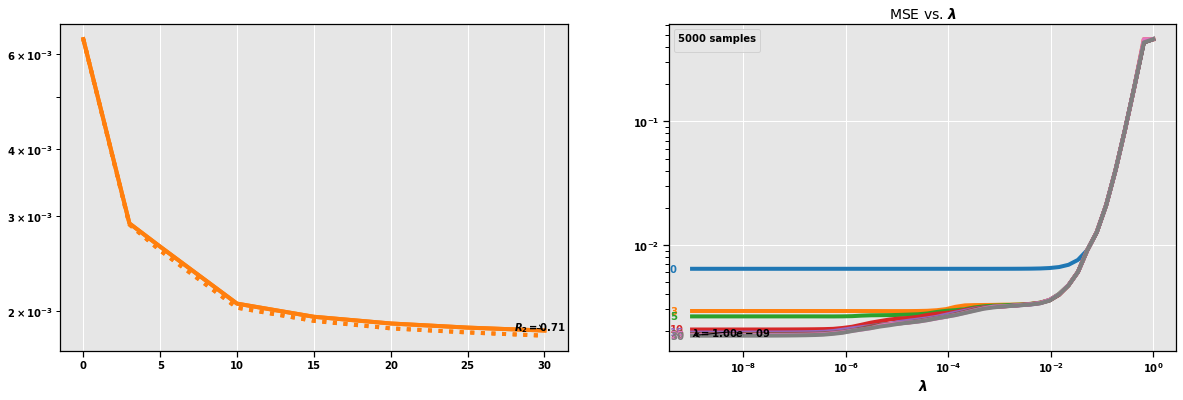

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=WIDE_FIG)


ax = axes[0]
test_best_lambda, test_best_mse = best_lambda_mse(df=lasso_df, polynomial_orders=polynomial_orders, col_prefix='test_mse_')
train_best_lambda, train_best_mse = best_lambda_mse(df=lasso_df, polynomial_orders=polynomial_orders, col_prefix='train_mse_')
ax.plot(polynomial_orders, test_best_mse, color=COLORS[1])
ax.plot(polynomial_orders, train_best_mse, ':', color=COLORS[1])

ax.plot(polynomial_orders, test_best_mse, color=COLORS[1])
ax.plot(polynomial_orders, train_best_mse, ':', color=COLORS[1])
ax.set_yscale('log')

# Data set for annotations and other subplots

best_mse_idx = np.argmin(test_best_mse)
best_mse_pn = polynomial_orders[best_mse_idx]
best_mse_val = test_best_mse[best_mse_idx]
best_mse_lambda_val = test_best_lambda[best_mse_idx]

# Annotate R2 for best MSE
xytext = (best_mse_pn-2, best_mse_val)
xy = (best_mse_pn, best_mse_val)
R2 = best_r2(test_best_mse, z_down)
ax.annotate(f'$R_2 = {R2:.2f}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})



''' MSE vs lambda '''
ax = axes[1]
ax.set_title(f"MSE vs. $\lambda$")
plot_orders = [3,7,10,13,15]
plot_orders = polynomial_orders
names = [f'test_mse_{pn}' for pn in plot_orders]
for name in names:
    ax.plot(lasso_df['lambda'], lasso_df[name])

for line, pn in zip(ax.lines, plot_orders):
    y = line.get_ydata()[0]
    ax.annotate(str(pn), xy=(0,y), xytext=(1,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=SMALL, va="center")    

ax.legend([], title=f'{sn} samples', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
ax.set_xlabel("$\lambda$")
#ax.set_ylabel("MSE")
ax.set_xscale('log')
ax.set_yscale('log')

# Annotate best lambda
xytext = (best_mse_lambda_val, best_mse_val)
xy = (best_mse_lambda_val, best_mse_val)
ax.annotate(f'$\lambda = {best_mse_lambda_val:.2e}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})


plt.show()

In [11]:
test_best_mse-train_best_mse

array([2.57288769e-05, 2.93513486e-05, 5.76057742e-05, 7.55996423e-05,
       9.94780327e-05, 1.45444762e-04, 1.80346564e-04, 1.72113154e-04,
       1.54415831e-04, 1.66482056e-04, 1.91211489e-04, 2.08112824e-04,
       2.01699722e-04, 1.91300703e-04, 1.84849238e-04, 1.86740279e-04,
       1.89540301e-04, 1.89491441e-04, 1.85935796e-04, 1.80118719e-04,
       1.74315537e-04, 1.71661710e-04, 1.73616624e-04, 1.78342251e-04,
       1.83324760e-04, 1.87083134e-04, 1.90804442e-04, 1.96119727e-04,
       2.03244871e-04, 2.10995916e-04])

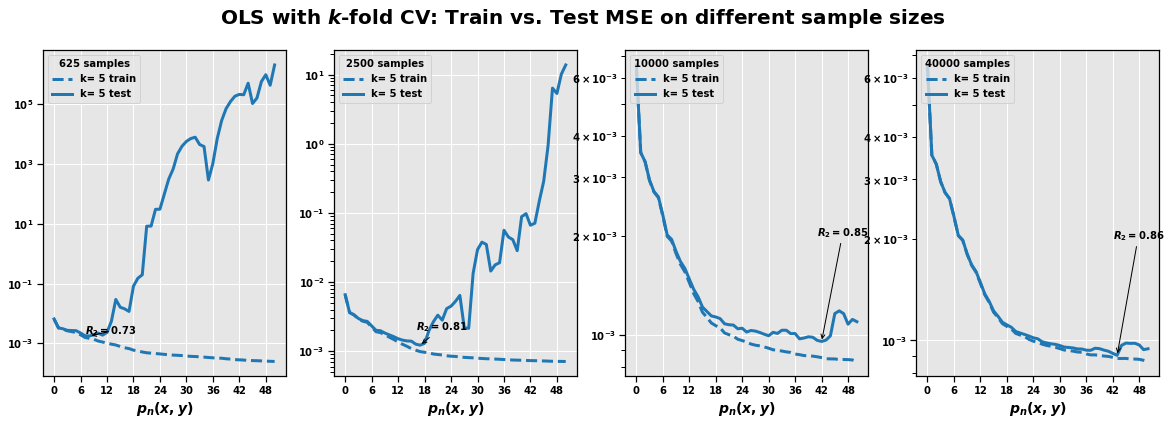

In [157]:
'''Plotting OLS with CV'''

plt.figure(figsize=WIDE_FIG)
plt.suptitle(r"OLS with $k$-fold CV: Train vs. Test MSE on different sample sizes", fontsize=LARGE, weight='bold')
ylim = (1E-2, 1E0)

plots = [141,142,143,144]
samples = [25*25,50*50,100*100,200*200]

for plot, sn in zip(plots, samples):
    plt.subplot(plot)
    X_down = X[:sn]
    z_down = z[:sn]
    legend = []
    for i, k in enumerate([5]):
        ols_k_df = run_ols_kfold(X_down, z_down, k=k, polynomial_orders=polynomial_orders)
        plt.plot(polynomial_orders, ols_k_df['train_mse'], '--', linewidth=THIN, color=COLORS[i])
        plt.plot(polynomial_orders, ols_k_df['test_mse'], linewidth=THIN, color=COLORS[i])
        legend += [f'k={k:2d} train', f'k={k:2d} test']
    plt.legend(legend, title=f'{sn} samples', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
    #plt.ylim(*ylim)
    plt.xlabel(r"$p_n(x,y)$")
    plt.yscale('log')
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # R2 annotation 
    best_idx = ols_k_df['test_mse'].argmin()
    best_mse_pn = polynomial_orders[best_idx]
    best_mse_val = ols_k_df['test_mse'].min()
    xytext = (best_mse_pn-1, .002)
    xy = (best_mse_pn, best_mse_val)
    R2 = best_r2(ols_k_df['test_mse'], z_down)
    plt.annotate(f'$R_2 = {R2:.2f}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})


plt.show()